In [217]:
import pandas as pd
import numpy as np
import datetime as dt
import pyodbc
import psycopg2
import math
import sys
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
import warnings
import pickle
from datetime import datetime
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500) 
spark.sql("set spark.sql.hive.convertMetastoreOrc=true")
conf.set("spark.driver.maxResultSize", "3g")
conf.set("spark.sql.parquet.writeLegacyFormat","true")

In [218]:
with open('strawberry_1014.pickle', 'rb') as file:
    strawberry = pickle.load(file)

The data I'm using is the dataset, which includes store, day, SKU level records with ordering from store - 'store-initiated' and headquarter 'pushes', sales, B-markdown units, and average selling price.  

In [219]:
# removing all the locs that has ZERO ordering data 
sum_df = strawberry.groupby('co_loc_i')[('total_prcs')].sum()
keep_lst = list(sum_df.index[sum_df.values != 0])
strawberry = strawberry.set_index('co_loc_i')
strawberry = strawberry.loc[keep_lst]

# dropping useless colums
strawberry = strawberry.drop(['lor', 'rcvd_1', 'rcvd_u', 'dpci_lbl_t', 'mdse_item_i'], axis = 1)
strawberry.head(5)

,co_loc_ref_i,mdse_item_desc_t,greg_d,asp,reg_s_u,prm_s_u,clr_s_u,ttl_s_u,b_mkdn_q,total_prcs,total_order_orig_req,total_order_prcs_q,si_ordered,other_ordered,total_push,md_shrtdt_push,mn_shrtdt_push,shrtdt_push,snsl_push,promo_push,other_push,str_fmt,msc_sgrp_desc_t
co_loc_i,,,,,,,,,,,,,,,,,,,,,,,
3,3,Strawberries - 1lb Package,2018-12-21,4.6742857142857142857,18,3,0,21,6.00,48.00,48.00,48.00,48.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2
3,3,Strawberries - 1lb Package,2018-12-22,4.7877777777777777778,23,4,0,27,35.00,8.00,32.00,8.00,32.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2
3,3,Strawberries - 1lb Package,2018-12-23,4.8485294117647058824,34,0,0,34,nan,24.00,48.00,24.00,48.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2
3,3,Strawberries - 1lb Package,2018-12-24,4.8250000000000000000,55,1,0,56,2.00,16.00,0.00,0.00,0.00,0.00,16.00,16.00,0.00,16.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2
3,3,Strawberries - 1lb Package,2018-12-25,None,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,P FRESH,PF OPEN CASE VO2


In [220]:
# Check how many stores left 
sum_df = strawberry.groupby('co_loc_i')[('total_prcs')].sum()
keep_lst = list(sum_df.index[sum_df.values != 0])
len(keep_lst)

1118

In [221]:
# Checking the missing values 
strawberry['asp'] = pd.to_numeric(strawberry['asp'])
strawberry['asp'] = strawberry['asp'].fillna(strawberry.groupby('co_loc_i')[('asp')].mean())
strawberry.fillna(0, inplace = True) 
strawberry.isnull().sum(axis = 0)

co_loc_ref_i            0
mdse_item_desc_t        0
greg_d                  0
asp                     0
reg_s_u                 0
prm_s_u                 0
clr_s_u                 0
ttl_s_u                 0
b_mkdn_q                0
total_prcs              0
total_order_orig_req    0
total_order_prcs_q      0
si_ordered              0
other_ordered           0
total_push              0
md_shrtdt_push          0
mn_shrtdt_push          0
shrtdt_push             0
snsl_push               0
promo_push              0
other_push              0
str_fmt                 0
msc_sgrp_desc_t         0
dtype: int64

In [222]:
# frmat cleanup a bit 
strawberry['asp'] = strawberry['asp'].astype(float).round(2)

In [223]:
df = strawberry
df.head(5)

,co_loc_ref_i,mdse_item_desc_t,greg_d,asp,reg_s_u,prm_s_u,clr_s_u,ttl_s_u,b_mkdn_q,total_prcs,total_order_orig_req,total_order_prcs_q,si_ordered,other_ordered,total_push,md_shrtdt_push,mn_shrtdt_push,shrtdt_push,snsl_push,promo_push,other_push,str_fmt,msc_sgrp_desc_t
co_loc_i,,,,,,,,,,,,,,,,,,,,,,,
3,3,Strawberries - 1lb Package,2018-12-21,4.67,18,3,0,21,6.00,48.00,48.00,48.00,48.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2
3,3,Strawberries - 1lb Package,2018-12-22,4.79,23,4,0,27,35.00,8.00,32.00,8.00,32.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2
3,3,Strawberries - 1lb Package,2018-12-23,4.85,34,0,0,34,0.00,24.00,48.00,24.00,48.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2
3,3,Strawberries - 1lb Package,2018-12-24,4.82,55,1,0,56,2.00,16.00,0.00,0.00,0.00,0.00,16.00,16.00,0.00,16.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2
3,3,Strawberries - 1lb Package,2018-12-25,2.82,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2


# What matters the most to markdowns in retail stores? 

For all the products within fresh food grocery, strawberry is always the one been throwing away the most. So I want to check if I can find reasons why then we may able to deal with it in the future. For Target, food that goes to waste usually called type B-markdown. Markdown values is, of course, the lower, the better. However, perishable food is generally hard to maintain a little waste while we need to take care of the out of stock rate. Thus here I'm going to explore inventory flow briefly, try to see if there are opportunities to improve. The primary metric in my analysis is the B-markdown rate - using B-markdown units divided by sales units. This metric indicates the level of the waste but not affected by sales velocity. For target, there are four kinds of store formats
: 
- P-Fresh Target: Selling a large percent of fresh groceries; PFresh was created in response to research and feedback from our guests who requested more fresh food selections. 
- Super Target: Largest store formant, usually at the suburban area that has high volume and most of the categories, including hardlines. 
- City Target: Very high traffic, but will generally be in a smaller format with a focus on both fresh grocery and living essentials. 
- Express Target: The smallest format of all, mostly close by the university, providing a limited assortment of fresh groceries and dorm/living essentials. 

Since P-Fresh is focusing more on the fresh grocery, I will dig into the waste analysis most in this store format. Then we have three main questions I want to know if the data could help provide informations.

### Sales & promotions interaction with B-markdown

My first step is to plot the B-markdown rate with the average selling price. The average selling price represented the retail price when items sold; that is to say, the low price is very likely due to the item is on sale.  So I plot the trend line of the selling price, hope to see the promotion leads to better sales, thus a lower B-markdown rate. Unfortunately, not seeing such pattern in the graphs. If it's not because of the selling price, what would be other possible factors?  Here I have a concern, which is strawberry is the item trendy in the market; customers will purchase the item with or without discount. Next time I will test out if the average selling price correlated with sells volumes. 

### Volume Group and their ordering behavior 

Then move forward to inventory flow: store ordering behavior. Since we want to research the orders from the stores to know do they place good orders or not, I want to define a defective order first. The over-ordering behavior is quickly causing the shrink because we cannot sell through before the item expired. I would say if the stores were placing order more then 3rd quantile of all the same store volume group, they probably order too often. Target P-Fresh Store Format Volume Groups are defined as the number lower; the higher is the velocity. In box-plots, demonstrate the order behavior affected by volumes. Based on it, I'm flagging each weekly level of data is that week is having more than 75% of the percentile in distribution.

### Ordering behavior with Bmarkdown
In the last two charts, I used the bar plot to present the percentages of how many times a bad order happened at the aggregated level of order data: 
- The sum of the instances when either order is larger than a store can possibly sell through  /  total order counts 
- The sum of the weekly order frequency locates at 1/4 of the highest distribution / total order counts 

However, after bringing in the B-Markdown percentages , the trends are not as correlated as I hope to see. 

# Conclusion 

In my hypothesis, there must be something that can lead to an over inventory scene, which is pushing up the wastes. The dataset I prepare this time may not show anything substantial as a prove yet. In the future, I may want to try a different category or re-define the 'defected' orders. For example, use the life of received, freshness, or the vendor information to help anchor the root cause of over-ordering. Could spend more time on the push, which is the HQ initiated orders too. In general, although we cannot draw a strong relationship by eyeballing the charts, we can run some tests on it to reject the hypothesis thoroughly as the following steps. 


In [224]:

df['wk_num'] = pd.to_datetime(df['greg_d']).dt.strftime('%Y-%U')

df['greg_d'] = pd.to_datetime(df['greg_d'])
df = df.set_index('greg_d')

drop_period = pd.date_range('12/21/2018', periods = 2, freq ='D').append(pd.date_range('10/6/2019', periods = 2, freq ='D'))

for i in drop_period: 
    df = df.drop(pd.to_datetime(i))

In [225]:
df['wk_num'].head(7)

greg_d
2018-12-23    2018-51
2018-12-24    2018-51
2018-12-25    2018-51
2018-12-26    2018-51
2018-12-27    2018-51
2018-12-28    2018-51
2018-12-29    2018-51
Name: wk_num, dtype: object

In [226]:
df[['b_mkdn_q','ttl_s_u','asp']].head(5)    

,b_mkdn_q,ttl_s_u,asp
greg_d,,,
2018-12-23,0.00,34,4.85
2018-12-24,2.00,56,4.82
2018-12-25,0.00,0,2.82
2018-12-26,1.00,27,4.54
2018-12-27,1.00,17,4.95


In [227]:
df_p_fresh = df[df['str_fmt'] == 'P FRESH'].groupby('wk_num')['b_mkdn_q','ttl_s_u'].sum()
df_p_fresh['asp'] = df[df['str_fmt'] == 'P FRESH'].groupby('wk_num')['asp'].mean()
df_p_fresh['BMD_PCT'] = ((df_p_fresh['b_mkdn_q'] / df_p_fresh['ttl_s_u'])*100.00).fillna(0)
df_p_fresh['wk_num'] = df_p_fresh.index

df_SUPER_TARGET = df[df['str_fmt'] == 'SUPER TARGET'].groupby('wk_num')['b_mkdn_q','ttl_s_u'].sum()
df_SUPER_TARGET['asp'] = df[df['str_fmt'] == 'SUPER TARGET'].groupby('wk_num')['asp'].mean()
df_SUPER_TARGET['BMD_PCT'] = ((df_SUPER_TARGET['b_mkdn_q'] / df_SUPER_TARGET['ttl_s_u'])*100.00).fillna(0)
df_SUPER_TARGET['wk_num'] = df_SUPER_TARGET.index

df_CITY_TARGET = df[df['str_fmt'] == 'CITY TARGET'].groupby('wk_num')['b_mkdn_q','ttl_s_u'].sum()
df_CITY_TARGET['asp'] = df[df['str_fmt'] == 'CITY TARGET'].groupby('wk_num')['asp'].mean()
df_CITY_TARGET['BMD_PCT'] = ((df_CITY_TARGET['b_mkdn_q'] / df_CITY_TARGET['ttl_s_u'])*100.00).fillna(0)
df_CITY_TARGET['wk_num'] = df_CITY_TARGET.index

df_EXPRESS_TARGET = df[df['str_fmt'] == 'EXPRESS TARGET'].groupby('wk_num')['b_mkdn_q','ttl_s_u'].sum()
df_EXPRESS_TARGET['asp'] = df[df['str_fmt'] == 'EXPRESS TARGET'].groupby('wk_num')['asp'].mean()
df_EXPRESS_TARGET['BMD_PCT'] = ((df_EXPRESS_TARGET['b_mkdn_q'] / df_EXPRESS_TARGET['ttl_s_u'])*100.00).fillna(0)
df_EXPRESS_TARGET['wk_num'] = df_EXPRESS_TARGET.index

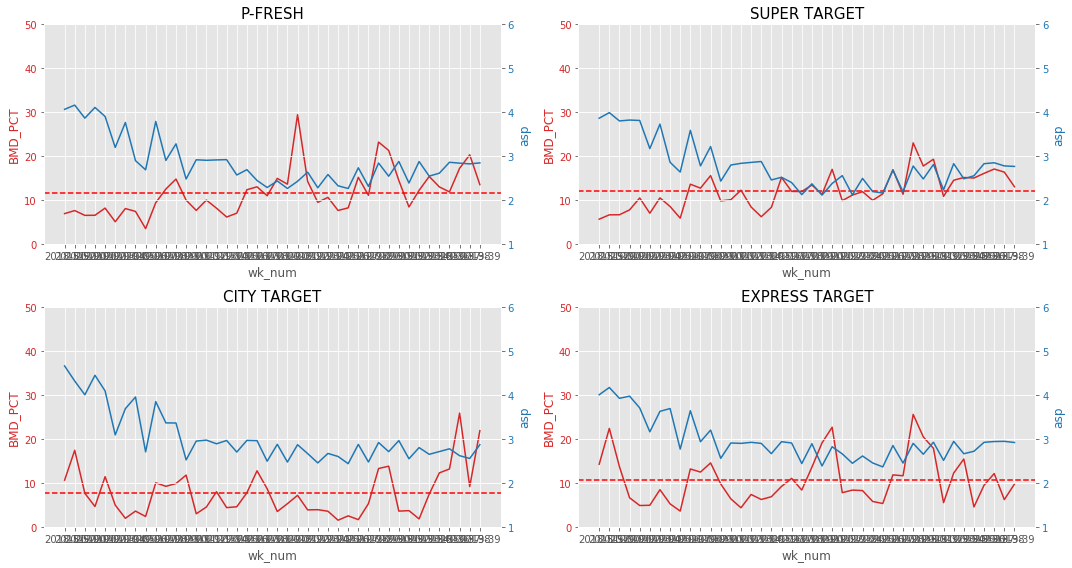

In [228]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,8))

color = 'tab:red'
ax1.set_xlabel('wk_num')
ax1.set_ylabel('BMD_PCT', color=color)
ax1.set_ylim(0,50)
ax1.plot(df_p_fresh['wk_num'], df_p_fresh['BMD_PCT'], color=color)
ax1.axhline(y = df_p_fresh['BMD_PCT'].mean(), linestyle='--', color='red')
ax1.tick_params(axis='y', labelcolor=color)

ax1_1 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1_1.set_ylabel('asp', color=color)  # we already handled the x-label with ax1
ax1_1.set_ylim(1, 6)
ax1_1.plot(df_p_fresh['wk_num'], df_p_fresh['asp'], color=color)
ax1_1.tick_params(axis='y', labelcolor=color)

plt.title('P-FRESH', fontsize = 15)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

color = 'tab:red'
ax2.set_xlabel('wk_num')
ax2.set_ylabel('BMD_PCT', color=color)
ax2.set_ylim(0,50)
ax2.axhline(y = df_SUPER_TARGET['BMD_PCT'].mean(), linestyle='--', color='red')
ax2.plot(df_SUPER_TARGET['wk_num'], df_SUPER_TARGET['BMD_PCT'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2_2 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2_2.set_ylabel('asp', color=color)  # we already handled the x-label with ax1
ax2_2.set_ylim(1, 6)
ax2_2.plot(df_SUPER_TARGET['wk_num'], df_SUPER_TARGET['asp'], color=color)
ax2_2.tick_params(axis='y', labelcolor=color)

plt.title('SUPER TARGET', fontsize = 15)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

color = 'tab:red'
ax3.set_xlabel('wk_num')
ax3.set_ylabel('BMD_PCT', color=color)
ax3.set_ylim(0,50)
ax3.axhline(y = df_CITY_TARGET['BMD_PCT'].mean(), linestyle='--', color='red')
ax3.plot(df_CITY_TARGET['wk_num'], df_CITY_TARGET['BMD_PCT'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax3_3 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3_3.set_ylabel('asp', color=color)  # we already handled the x-label with ax1
ax3_3.set_ylim(1, 6)
ax3_3.plot(df_CITY_TARGET['wk_num'], df_CITY_TARGET['asp'], color=color)
ax3_3.tick_params(axis='y', labelcolor=color)

plt.title('CITY TARGET', fontsize = 15)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

color = 'tab:red'
ax4.set_xlabel('wk_num')
ax4.set_ylabel('BMD_PCT', color=color)
ax4.set_ylim(0,50)
ax4.axhline(y = df_EXPRESS_TARGET['BMD_PCT'].mean(), linestyle='--', color='red')
ax4.plot(df_EXPRESS_TARGET['wk_num'], df_EXPRESS_TARGET['BMD_PCT'], color=color)
ax4.tick_params(axis='y', labelcolor=color)

ax4_4 = ax4.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4_4.set_ylabel('asp', color=color)  # we already handled the x-label with ax1
ax4_4.set_ylim(1, 6)
ax4_4.plot(df_EXPRESS_TARGET['wk_num'], df_EXPRESS_TARGET['asp'], color=color)
ax4_4.tick_params(axis='y', labelcolor=color)

plt.title('EXPRESS TARGET', fontsize = 15)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

As shown in the graphs, the selling price (promotion indicator) are not aligned with the B-markdown values, which is surprising to me. In my assumptions, I have the hypothesis that with the price drop, the sales increase, thus decrease the waste. In all four formats of stores, the store format with higher volumn (SUPER TARGET, CITY TARGET ) has a more stable B-markdown, which is expected. Spikes are more easily observed in P-Fresh and Express Target, which have lower traffic.

In [229]:
df = pd.DataFrame()
df = strawberry
df.head(5)

,co_loc_ref_i,mdse_item_desc_t,greg_d,asp,reg_s_u,prm_s_u,clr_s_u,ttl_s_u,b_mkdn_q,total_prcs,total_order_orig_req,total_order_prcs_q,si_ordered,other_ordered,total_push,md_shrtdt_push,mn_shrtdt_push,shrtdt_push,snsl_push,promo_push,other_push,str_fmt,msc_sgrp_desc_t,wk_num
co_loc_i,,,,,,,,,,,,,,,,,,,,,,,,
3,3,Strawberries - 1lb Package,2018-12-21,4.67,18,3,0,21,6.00,48.00,48.00,48.00,48.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2,2018-50
3,3,Strawberries - 1lb Package,2018-12-22,4.79,23,4,0,27,35.00,8.00,32.00,8.00,32.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2,2018-50
3,3,Strawberries - 1lb Package,2018-12-23,4.85,34,0,0,34,0.00,24.00,48.00,24.00,48.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2,2018-51
3,3,Strawberries - 1lb Package,2018-12-24,4.82,55,1,0,56,2.00,16.00,0.00,0.00,0.00,0.00,16.00,16.00,0.00,16.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2,2018-51
3,3,Strawberries - 1lb Package,2018-12-25,2.82,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2,2018-51


In [230]:
df = df[(df['str_fmt'] == 'P FRESH') & (df['msc_sgrp_desc_t'] != 0)]
df['wk_num'] = pd.to_datetime(df['greg_d']).dt.strftime('%Y-%U')
df = df[(df['wk_num'] != '2018-52') & (df['wk_num'] != '2018-51') & (df['wk_num'] != '2018-50') & (df['wk_num'] != '2019-00') ]

In [231]:
df['f_str_ord'] = np.where(df['si_ordered'] > 0, 1, 0)
df['f_ord_sz_lgr_coming_sls'] = np.where(df['si_ordered'] > (df['ttl_s_u'].shift(-5).rolling(5).sum()), 1, 0)

In [232]:
df.head(3)

,co_loc_ref_i,mdse_item_desc_t,greg_d,asp,reg_s_u,prm_s_u,clr_s_u,ttl_s_u,b_mkdn_q,total_prcs,total_order_orig_req,total_order_prcs_q,si_ordered,other_ordered,total_push,md_shrtdt_push,mn_shrtdt_push,shrtdt_push,snsl_push,promo_push,other_push,str_fmt,msc_sgrp_desc_t,wk_num,f_str_ord,f_ord_sz_lgr_coming_sls
co_loc_i,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,Strawberries - 1lb Package,2019-01-06,4.19,20,3,0,23,3.00,96.00,96.00,96.00,96.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2,2019-01,1,0
3,3,Strawberries - 1lb Package,2019-01-07,4.17,17,4,0,21,0.00,72.00,48.00,48.00,48.00,0.00,24.00,0.00,24.00,24.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2,2019-01,1,0
3,3,Strawberries - 1lb Package,2019-01-08,4.32,17,2,0,19,2.00,8.00,0.00,0.00,0.00,0.00,8.00,0.00,8.00,8.00,0.00,0.00,0.00,P FRESH,PF OPEN CASE VO2,2019-01,0,0


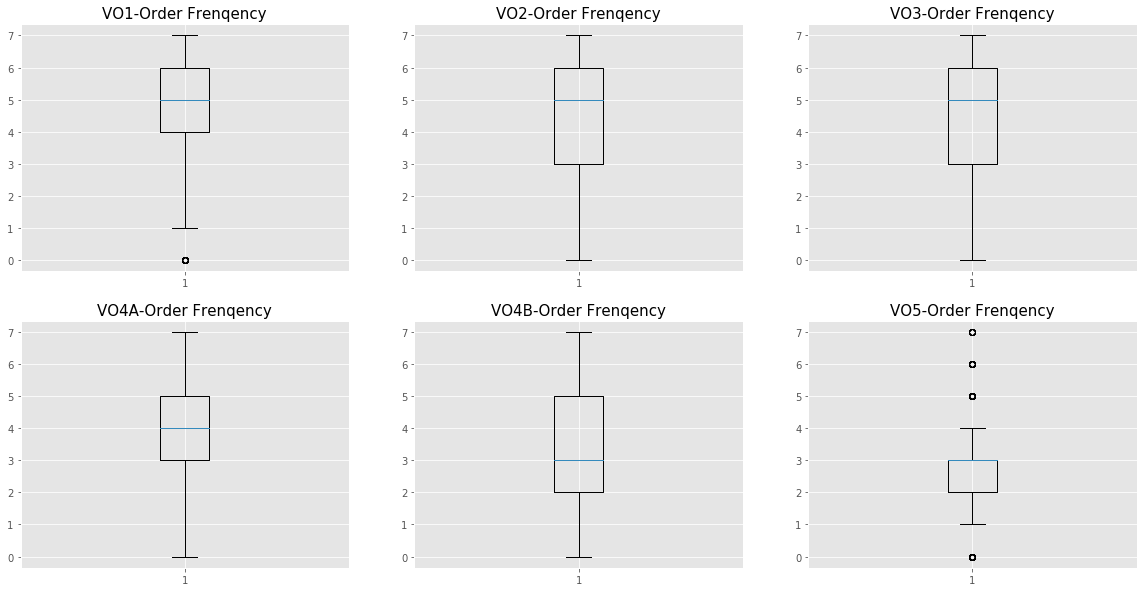

In [233]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.boxplot(df[(df['str_fmt'] == 'P FRESH') & (df['msc_sgrp_desc_t'] == 'PF OPEN CASE VO1')].groupby(['co_loc_ref_i','wk_num'])['f_str_ord'].sum())
plt.title('VO1-Order Frenqency', fontsize = 15)

plt.subplot(2, 3, 2)
plt.boxplot(df[(df['str_fmt'] == 'P FRESH') & (df['msc_sgrp_desc_t'] == 'PF OPEN CASE VO2')].groupby(['co_loc_ref_i','wk_num'])['f_str_ord'].sum())
plt.title('VO2-Order Frenqency', fontsize = 15)

plt.subplot(2, 3, 3)
plt.boxplot(df[(df['str_fmt'] == 'P FRESH') & (df['msc_sgrp_desc_t'] == 'PF OPEN CASE VO3')].groupby(['co_loc_ref_i','wk_num'])['f_str_ord'].sum())
plt.title('VO3-Order Frenqency', fontsize = 15)

plt.subplot(2, 3, 4)
plt.boxplot(df[(df['str_fmt'] == 'P FRESH') & (df['msc_sgrp_desc_t'] == 'PF OPEN CASE VO4-A')].groupby(['co_loc_ref_i','wk_num'])['f_str_ord'].sum())
plt.title('VO4A-Order Frenqency', fontsize = 15)

plt.subplot(2, 3, 5)
plt.boxplot(df[(df['str_fmt'] == 'P FRESH') & (df['msc_sgrp_desc_t'] == 'PF OPEN CASE VO4-B')].groupby(['co_loc_ref_i','wk_num'])['f_str_ord'].sum())
plt.title('VO4B-Order Frenqency', fontsize = 15)

plt.subplot(2, 3, 6)
plt.boxplot(df[(df['str_fmt'] == 'P FRESH') & (df['msc_sgrp_desc_t'] == 'PF OPEN CASE VO5')].groupby(['co_loc_ref_i','wk_num'])['f_str_ord'].sum())
plt.title('VO5-Order Frenqency', fontsize = 15)

plt.show()

In [234]:
df_sum = pd.DataFrame()

df_sum['wk_ord_freq'] = (df.groupby(['co_loc_ref_i','wk_num','msc_sgrp_desc_t'])['f_str_ord'].sum())
df_sum['wk_ord_size'] = df.groupby(['co_loc_ref_i','wk_num','msc_sgrp_desc_t'])['si_ordered'].sum()
df_sum['wk_ord_sz_lgr_coming_sls'] = df.groupby(['co_loc_ref_i','wk_num','msc_sgrp_desc_t'])['f_ord_sz_lgr_coming_sls'].sum()
df_sum['bmd'] = df.groupby(['co_loc_ref_i','wk_num','msc_sgrp_desc_t'])['b_mkdn_q'].sum()
df_sum['sls'] = df.groupby(['co_loc_ref_i','wk_num','msc_sgrp_desc_t'])['ttl_s_u'].sum()

df_sum['vo_grp'] = df_sum.index.get_level_values(2) 
df_sum.head(5)

wk_ord_freq  wk_ord_size  \
co_loc_ref_i wk_num  msc_sgrp_desc_t                              
3            2019-01 PF OPEN CASE VO2            2       144.00   
             2019-02 PF OPEN CASE VO2            6       208.00   
             2019-03 PF OPEN CASE VO2            6       240.00   
             2019-04 PF OPEN CASE VO2            5       240.00   
             2019-05 PF OPEN CASE VO2            7       624.00   

                                       wk_ord_sz_lgr_coming_sls    bmd  sls  \
co_loc_ref_i wk_num  msc_sgrp_desc_t                                          
3            2019-01 PF OPEN CASE VO2                         0 104.00  149   
             2019-02 PF OPEN CASE VO2                         0   4.00  201   
             2019-03 PF OPEN CASE VO2                         0  66.00  180   
             2019-04 PF OPEN CASE VO2                         0  10.00  178   
             2019-05 PF OPEN CASE VO2                         0  26.00  211   

                                                 vo_grp  
co_loc_ref_i wk_num  msc_sgrp_desc_t                     
3            2019-01 PF OPEN CASE VO2  PF OPEN CASE VO2  
             2019-02 PF OPEN CASE VO2  PF OPEN CASE VO2  
             2019-03 PF OPEN CASE VO2  PF OPEN CASE VO2  
             2019-04 PF OPEN CASE VO2  PF OPEN CASE VO2  
             2019-05 PF OPEN CASE VO2  PF OPEN CASE VO2

In [235]:
s = df_sum
for column in s.columns:
 if s[column].dtype == object:
  dummyCols = pd.get_dummies(s[column])
  s = s.join(dummyCols)
  del s[column]

In [236]:
#s['co_loc_ref_i'] = s.index.get_level_values(0) 
#s['wk_num'] = s.index.get_level_values(1) 

In [237]:
s['f_wk_ord_freq_lgr_3qtr'] = np.where( \
    ( \
        ((s['PF OPEN CASE VO5'] == 1) & (s['wk_ord_freq'] >= 3)) | \
        ((s['PF OPEN CASE VO4-A'] == 1) & (s['wk_ord_freq'] >= 5)) | \
        ((s['PF OPEN CASE VO4-B'] == 1) & (s['wk_ord_freq'] >= 5)) | \
        ((s['PF OPEN CASE VO3'] == 1) & (s['wk_ord_freq'] >= 6)) | \
        ((s['PF OPEN CASE VO2'] == 1) & (s['wk_ord_freq'] >= 6)) | \
        ((s['PF OPEN CASE VO1'] == 1) & (s['wk_ord_freq'] >= 6)) \
     ), 1, 0 \
                                        )       
s = s.drop(['PF OPEN CASE VO5','PF OPEN CASE VO4-B','PF OPEN CASE VO4-A','PF OPEN CASE VO3','PF OPEN CASE VO2','PF OPEN CASE VO1'], axis = 1)

In [238]:
s.head(10)

wk_ord_freq  wk_ord_size  \
co_loc_ref_i wk_num  msc_sgrp_desc_t                              
3            2019-01 PF OPEN CASE VO2            2       144.00   
             2019-02 PF OPEN CASE VO2            6       208.00   
             2019-03 PF OPEN CASE VO2            6       240.00   
             2019-04 PF OPEN CASE VO2            5       240.00   
             2019-05 PF OPEN CASE VO2            7       624.00   
             2019-06 PF OPEN CASE VO2            6       368.00   
             2019-07 PF OPEN CASE VO2            7       352.00   
             2019-08 PF OPEN CASE VO2            6       352.00   
             2019-09 PF OPEN CASE VO2            7       352.00   
             2019-10 PF OPEN CASE VO2            6       216.00   

                                       wk_ord_sz_lgr_coming_sls    bmd  sls  \
co_loc_ref_i wk_num  msc_sgrp_desc_t                                          
3            2019-01 PF OPEN CASE VO2                         0 104.00  149   
             2019-02 PF OPEN CASE VO2                         0   4.00  201   
             2019-03 PF OPEN CASE VO2                         0  66.00  180   
             2019-04 PF OPEN CASE VO2                         0  10.00  178   
             2019-05 PF OPEN CASE VO2                         0  26.00  211   
             2019-06 PF OPEN CASE VO2                         0  10.00  414   
             2019-07 PF OPEN CASE VO2                         0  23.00  188   
             2019-08 PF OPEN CASE VO2                         0  46.00  353   
             2019-09 PF OPEN CASE VO2                         0  11.00  185   
             2019-10 PF OPEN CASE VO2                         0  32.00  211   

                                       f_wk_ord_freq_lgr_3qtr  
co_loc_ref_i wk_num  msc_sgrp_desc_t                           
3            2019-01 PF OPEN CASE VO2                       0  
             2019-02 PF OPEN CASE VO2                       1  
             2019-03 PF OPEN CASE VO2                       1  
             2019-04 PF OPEN CASE VO2                       0  
             2019-05 PF OPEN CASE VO2                       1  
             2019-06 PF OPEN CASE VO2                       1  
             2019-07 PF OPEN CASE VO2                       1  
             2019-08 PF OPEN CASE VO2                       1  
             2019-09 PF OPEN CASE VO2                       1  
             2019-10 PF OPEN CASE VO2                       1

In [239]:
wk_sum = s.groupby(['wk_num']).sum()
wk_sum.head(5)

,wk_ord_freq,wk_ord_size,wk_ord_sz_lgr_coming_sls,bmd,sls,f_wk_ord_freq_lgr_3qtr
wk_num,,,,,,
2019-01,3370,"115,000.00",64,"7,123.00",108725,289
2019-02,3682,"137,504.00",102,"8,637.00",105305,353
2019-03,4020,"163,800.00",378,"5,752.00",112739,437
2019-04,3663,"148,512.00",207,"7,477.00",92212,348
2019-05,3576,"135,704.00",100,"8,477.00",113531,331


In [240]:
wk_sum['wk_bmd_pct'] = (wk_sum['bmd'] / wk_sum['sls'] * 100.00).fillna(0)
wk_sum['f_wk_ord_freq_lgr_3qtr'] = (wk_sum['f_wk_ord_freq_lgr_3qtr'] / wk_sum['wk_ord_freq']* 100.00).fillna(0)
wk_sum['wk_ord_sz_lgr_coming_sls'] = (wk_sum['wk_ord_sz_lgr_coming_sls'] / wk_sum['wk_ord_freq']* 100.00).fillna(0)
wk_sum.head(5)

,wk_ord_freq,wk_ord_size,wk_ord_sz_lgr_coming_sls,bmd,sls,f_wk_ord_freq_lgr_3qtr,wk_bmd_pct
wk_num,,,,,,,
2019-01,3370,"115,000.00",1.90,"7,123.00",108725,8.58,6.55
2019-02,3682,"137,504.00",2.77,"8,637.00",105305,9.59,8.20
2019-03,4020,"163,800.00",9.40,"5,752.00",112739,10.87,5.10
2019-04,3663,"148,512.00",5.65,"7,477.00",92212,9.50,8.11
2019-05,3576,"135,704.00",2.80,"8,477.00",113531,9.26,7.47


In [244]:
wk_sum['wk_num'] = wk_sum.index

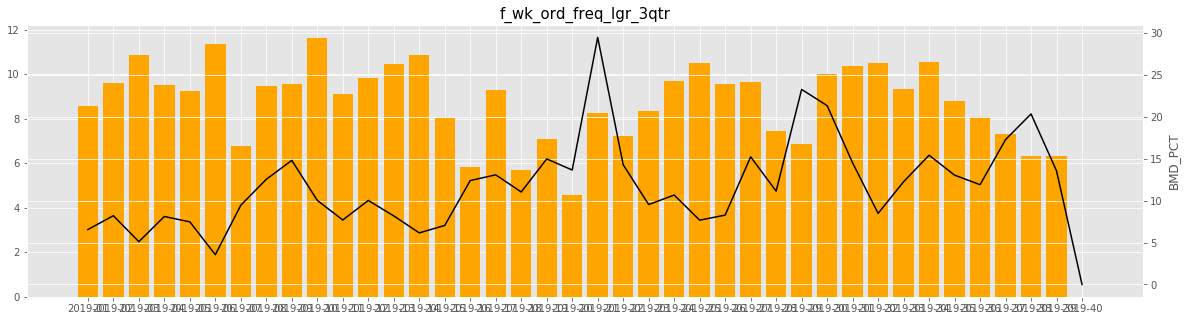

In [242]:
plt.figure(figsize=(20,5))

plt.title('f_wk_ord_freq_lgr_3qtr', fontsize = 15)
values = wk_sum['f_wk_ord_freq_lgr_3qtr']
bars = (wk_sum['wk_num'])
y_pos = np.arange(len(bars))
plt.bar(y_pos, values, color='orange' )
plt.xticks(y_pos, bars)

axes2 = plt.twinx()
axes2.plot(wk_sum['wk_num'], wk_sum['wk_bmd_pct'], color='k', label='Sine')
axes2.set_ylabel('BMD_PCT')

plt.show()

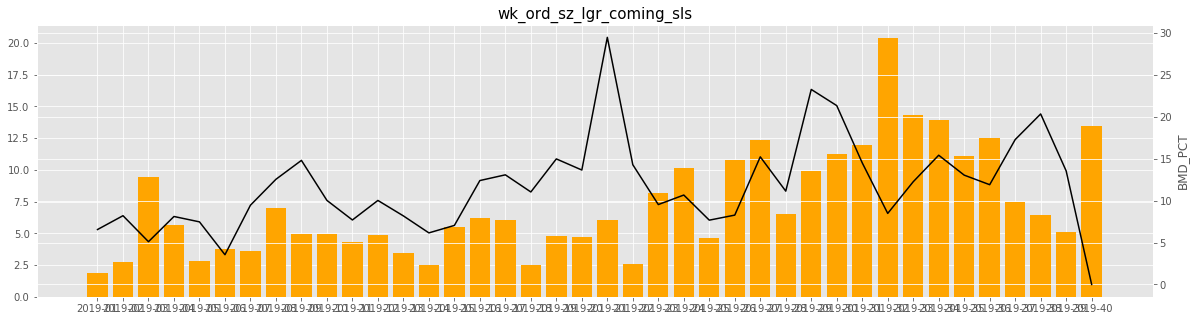

In [245]:
plt.figure(figsize=(20,5))

plt.title('wk_ord_sz_lgr_coming_sls', fontsize = 15)
values = wk_sum['wk_ord_sz_lgr_coming_sls']
bars = (wk_sum['wk_num'])
y_pos = np.arange(len(bars))
plt.bar(y_pos, values, color='orange' )
plt.xticks(y_pos, bars)

axes2 = plt.twinx()
axes2.plot(wk_sum['wk_num'], wk_sum['wk_bmd_pct'], color='k', label='Sine')
axes2.set_ylabel('BMD_PCT')

plt.show()